# Introduction

Users download software for different purposes of use. Because paying service is usually better off offering pleasant experience, and free apps are more accessible to everyone, what are the user's views on these apps? 

In [218]:
# import packages

import pandas as pd
import seaborn as sns
import numpy as np
import re
from scipy.stats import mannwhitneyu
from matplotlib import pyplot as plt
import warnings

In [191]:
# Read dataframe and display data
df = pd.read_csv('googleplaystore.csv')
df.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


# Prepare Dataframe

<b>The data types of each feature must be changed to a proper format that can be used for analysis.The data types of each feature must be changed to a proper format that can be used for analysis.</b>

In [192]:
df.dtypes  # Displaying Data types of each feature.

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

<b>The feature Reviews must be of numerical type. So we should change it.</b>

In [193]:
df['Reviews'] = df['Reviews'].apply(pd.to_numeric, args=('coerce',)) #Changing to int type.
df['Installs'] = df['Installs'].apply(pd.to_numeric, args=('coerce',)) #Changing to int type.
df['Price'] = df['Price'].apply(pd.to_numeric, args=('coerce',)) #Changing to int type.

<b>Other Features like Size, Installs, Price and Android Vers also must be of numeric type.
The values they are holding must be changed to a proper format so that we can use them for analysis and plots. </b>

<b> 
Changing the feature : Size
 </b>

In [194]:
newSize = []

for row in df.Size:
    newrow = row[:-1]
    try:
        newSize.append(float(newrow))
    except:
        newSize.append(0) #When it says - Size Varies.
    
df.Size = newSize

df.Size.head()

0    19.0
1    14.0
2     8.7
3    25.0
4     2.8
Name: Size, dtype: float64

<b> 
Changing the feature, Android Ver </b>

In [195]:
newVer = []

for row in df['Android Ver']:
    try:
        newrow = float(row[:2])
    except:
        newrow = 0  # When the value is - Varies with device
    
    newVer.append(newrow)
    
df['Android Ver'] =  newVer

df['Android Ver'].value_counts()

4.0    6959
0.0    1365
2.0    1351
5.0     629
3.0     287
1.0     138
6.0      60
7.0      46
8.0       6
Name: Android Ver, dtype: int64

In [196]:
# check duplicates
n_duplicated = df.duplicated(subset=['App']).sum()
print("There are {}/{} duplicated records.".format(n_duplicated, df.shape[0]))
df_no_dup = df.drop(df.index[df.App.duplicated()], axis=0)
print("{} records after dropping duplicated.".format(df_no_dup.shape[0]))

There are 1181/10841 duplicated records.
9660 records after dropping duplicated.


In [197]:
# Check and clean type values, defer nan value processing to the next cell
print(set(df_no_dup.Type))
print("Dropping alien Type value '0', {} record(s) removed".format(sum(df_no_dup.Type == '0')))
df_no_dup = df_no_dup.drop(df_no_dup.index[df_no_dup.Type == '0'], axis=0)

{'Paid', nan, '0', 'Free'}
Dropping alien Type value '0', 1 record(s) removed


In [198]:
# check and drop NaN values
print("NaA value statistics in each column")
print(df_no_dup.isnull().sum(axis=0),'\n')
df_no_dup = df_no_dup.dropna(subset=['Type'])
print("Column 'Type' with NaN values are dropped, {} records left.".format(df_no_dup.shape[0]))

# prepare rating dataframe
df_rating = df_no_dup.dropna(subset=['Rating'])
print("Cleaned dataframe for 'Rating' has {} records.".format(df_rating.shape[0]))
# prepare reviews dataframe
df_reviews = df_no_dup.dropna(subset=['Reviews'])
print("Cleaned dataframe for 'Reviews' has {} records.".format(df_reviews.shape[0]))

NaA value statistics in each column
App                  0
Category             0
Rating            1463
Reviews              0
Size                 0
Installs          9658
Type                 1
Price              756
Content Rating       0
Genres               0
Last Updated         0
Current Ver          8
Android Ver          0
dtype: int64 

Column 'Type' with NaN values are dropped, 9658 records left.
Cleaned dataframe for 'Rating' has 8196 records.
Cleaned dataframe for 'Reviews' has 9658 records.


In [199]:
# we are interested in the columns Category, Rating and Type
# Drop irrelevant columns for Rating dataframe.
df_rating = df_rating.loc[:,['Rating', 'Type', 'Category']]

# Visulaizations Functions

In [200]:
def plot_hist(df, col, bins=10):
    """
    Plot histograms for a column
    """
    plt.hist(df[col], bins=bins)
    plt.xlabel(col)
    plt.ylabel('counts')
    plt.title('Distribution of {}'.format(col))

def compute_app_types(df):
    """
    Given a dataframe, compute the number 
    of free and paid apps respectively
    """
    return sum(df.Type == "Free"), sum(df.Type == 'Paid')

def plot_app_types(df):
    """
    Plot app type distributions across categories
    """
    vc_rating = df.Category.value_counts()
    cat_free_apps = []
    cat_paid_apps = []
    for cat in vc_rating.index:
        n_free, n_paid = compute_app_types(df.query("Category == '{}'".format(cat)))
        cat_free_apps.append(n_free)
        cat_paid_apps.append(n_paid)

    f, ax = plt.subplots(2,1)
    ax[0].bar(range(1, len(cat_free_apps)+1), cat_free_apps)
    ax[1].bar(range(1, len(cat_free_apps)+1), cat_paid_apps)

def drop_categories(df):
    """
    Drop categories with any app type with instances fewer than 10
    """
    vc_rating = df.Category.value_counts()
    cats_to_drop = []
    for cat in vc_rating.index:
        n_free, n_paid = compute_app_types(df.query("Category == '{}'".format(cat)))
        if n_free < 10 or n_paid < 10:
            cats_to_drop.append(cat)
    for cat in cats_to_drop:
        df.drop(df.query('Category == "{}"'.format(cat)).index, axis=0, inplace=True)
    print("Deleted categories: {}".format(cats_to_drop))
    return df

# Explore and Analysis

# Categorization

<b>Displaying all the categories and their counts.</b>

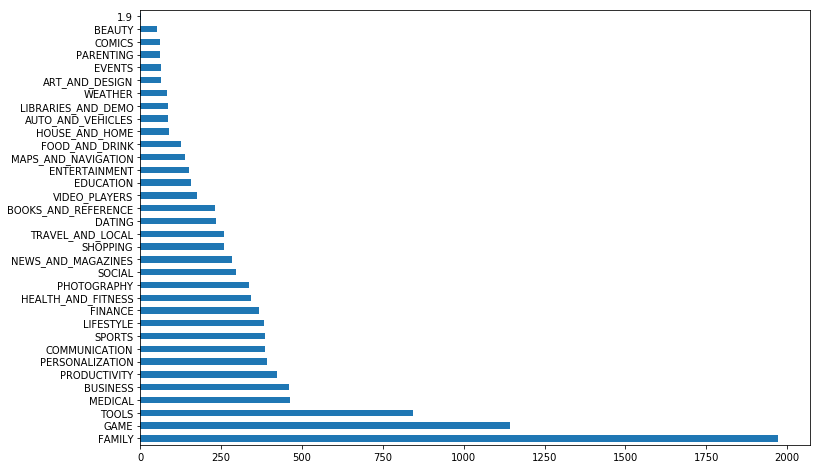

In [201]:
df.Category.value_counts()
df.Category.value_counts().plot(kind='barh',figsize= (12,8))

# Rating

,Rating
count,8196.000000
mean,4.173243
std,0.536625
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,5.000000


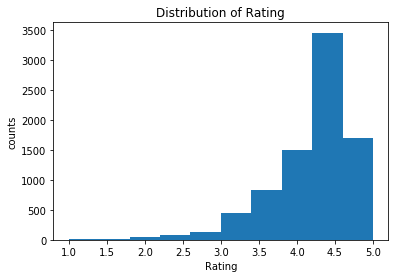

In [202]:
# Describe Rating dataframe
plot_hist(df_rating, 'Rating')
df_rating.describe()

In [203]:
print("No. of Apps with full ratings: ",df.Rating[df['Rating'] == 5 ].count())

No. of Apps with full ratings:  274


<b>There are 271 Apps in the store which hold 5.0 Ratings. Do all of these actually deserve it? Or are these spammed ratings? .</b>

#  Consider the Reviews:

<b>Distribution Plot of the feature 'Reviews'</b>

,Rating,Reviews,Size,Installs,Price,Android Ver
count,8196.000000,9.658000e+03,9658.00000,0.0,8902.0,9658.000000
mean,4.173243,2.166150e+05,32.41989,NaN,0.0,3.332263
std,0.536625,1.831413e+06,96.48871,NaN,0.0,1.422346
min,1.000000,0.000000e+00,0.00000,NaN,0.0,0.000000
25%,4.000000,2.500000e+01,3.40000,NaN,0.0,2.000000
50%,4.300000,9.670000e+02,10.00000,NaN,0.0,4.000000
75%,4.500000,2.940800e+04,28.00000,NaN,0.0,4.000000
max,5.000000,7.815831e+07,1020.00000,NaN,0.0,8.000000


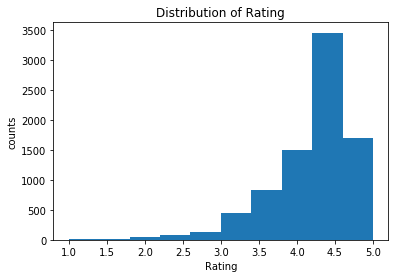

In [204]:
plot_hist(df_reviews, 'Rating')
df_reviews.describe()

In [205]:
df[df.Reviews>40000000]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
335,Messenger – Text and Video Chat for Free,COMMUNICATION,4.0,56642847.0,0.0,NaN,Free,0.0,Everyone,Communication,"August 1, 2018",Varies with device,0.0
336,WhatsApp Messenger,COMMUNICATION,4.4,69119316.0,0.0,NaN,Free,0.0,Everyone,Communication,"August 3, 2018",Varies with device,0.0
381,WhatsApp Messenger,COMMUNICATION,4.4,69119316.0,0.0,NaN,Free,0.0,Everyone,Communication,"August 3, 2018",Varies with device,0.0
382,Messenger – Text and Video Chat for Free,COMMUNICATION,4.0,56646578.0,0.0,NaN,Free,0.0,Everyone,Communication,"August 1, 2018",Varies with device,0.0
1670,Clash of Clans,GAME,4.6,44891723.0,98.0,NaN,Free,0.0,Everyone 10+,Strategy,"July 15, 2018",10.322.16,4.0
1704,Clash of Clans,GAME,4.6,44891723.0,98.0,NaN,Free,0.0,Everyone 10+,Strategy,"July 15, 2018",10.322.16,4.0
1879,Clash of Clans,GAME,4.6,44893888.0,98.0,NaN,Free,0.0,Everyone 10+,Strategy,"July 15, 2018",10.322.16,4.0
2544,Facebook,SOCIAL,4.1,78158306.0,0.0,NaN,Free,0.0,Teen,Social,"August 3, 2018",Varies with device,0.0
2545,Instagram,SOCIAL,4.5,66577313.0,0.0,NaN,Free,0.0,Teen,Social,"July 31, 2018",Varies with device,0.0
2604,Instagram,SOCIAL,4.5,66577446.0,0.0,NaN,Free,0.0,Teen,Social,"July 31, 2018",Varies with device,0.0


<b>The most famous Apps like Messanger, WhatsApp, Facebook and Clash of Clans are the most reviewed Apps as shown above.</b>

In [206]:
print("There are {} free and {} paid apps in the the Rating dataframe ".format(*compute_app_types(df_rating)))

There are 7592 free and 604 paid apps in the the Rating dataframe 


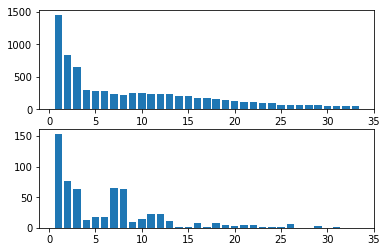

In [207]:
# explore the distributions of free and paid apps across different categories
plot_app_types(df_rating)

In [208]:
# Exclude categories with fewer than 10 apps for any Free or Paid type
# Otherwise the categories would contain too few data to generalize the result
df_rating = drop_categories(df_rating)
print("Cleaned Rating dataframe has {} datapoints".format(df_rating.shape[0]))

Deleted categories: ['BUSINESS', 'NEWS_AND_MAGAZINES', 'SOCIAL', 'TRAVEL_AND_LOCAL', 'SHOPPING', 'BOOKS_AND_REFERENCE', 'VIDEO_PLAYERS', 'DATING', 'EDUCATION', 'MAPS_AND_NAVIGATION', 'ENTERTAINMENT', 'FOOD_AND_DRINK', 'AUTO_AND_VEHICLES', 'WEATHER', 'LIBRARIES_AND_DEMO', 'HOUSE_AND_HOME', 'ART_AND_DESIGN', 'COMICS', 'PARENTING', 'EVENTS', 'BEAUTY']
Cleaned Rating dataframe has 5753 datapoints


In [209]:
df_rating.describe()

,Rating
count,5753.000000
mean,4.173197
std,0.544844
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,5.000000


# Android Ver

In [210]:
df['Android Ver'].value_counts()

4.0    6959
0.0    1365
2.0    1351
5.0     629
3.0     287
1.0     138
6.0      60
7.0      46
8.0       6
Name: Android Ver, dtype: int64

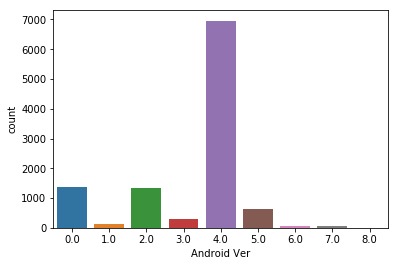

In [211]:
sns.countplot(df['Android Ver'])

<b> How does the ratings differ in general? </b>

In [212]:
def plot_target_by_group(df, target_col, group_col, figsize=(6,4), title=""):
    """
    Plot the mean of a target column (Numeric) groupped by the group column (categorical)
    """
    order = sorted(list(set(df[group_col])))
    stats = df.groupby(group_col).mean()[target_col]
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x=group_col, y=target_col, data=df, ax=ax, order=order).set_title(title)
    ax.set(ylim=(3.8, 4.5))    
    return stats

Free app has average Rating 4.163495108382891
Paid app has average Rating 4.266851851851849
Mean rating: 4.173196593081873


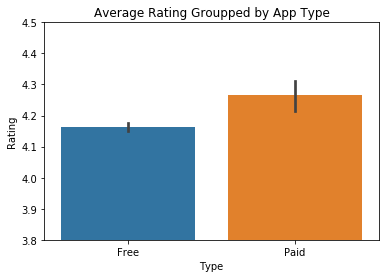

In [213]:
stats = plot_target_by_group(df_rating, 'Rating', 'Type', title="Average Rating Groupped by App Type")
for i, s in zip(stats.index, stats):
    print("{} app has average {} {}".format(i, 'Rating',s))
mean_rating = df_rating.Rating.mean()
print("Mean rating: {}".format(mean_rating))

<b>Interpretation</b>

In general, Free apps, with an average rating of 4.16, are lower rated than Paid apps with an average rating of 4.27. And the average rating for all apps is 4.17, so Free apps are rated below average, while Paid apps are rated reletively higher than the average score.


<b>How are the differences distributed across different app categories?</b>

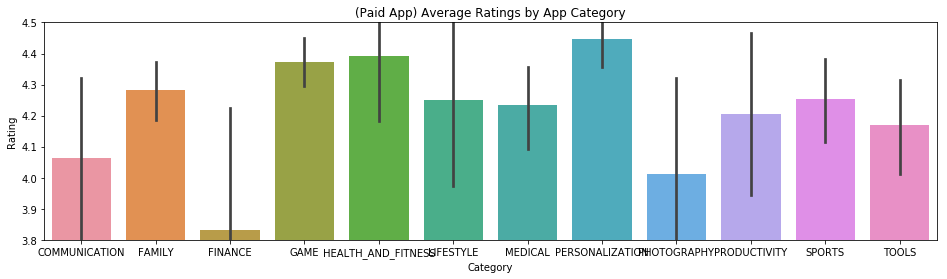

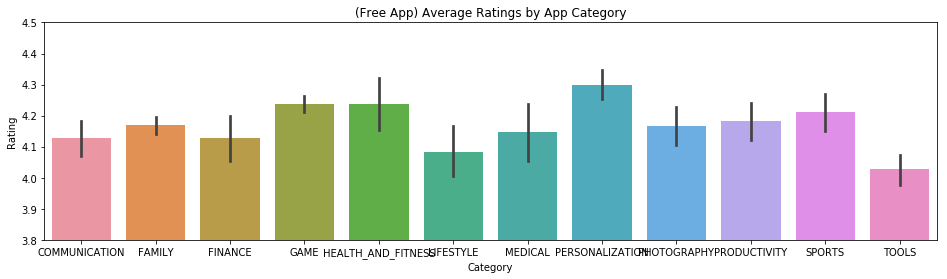

In [214]:
paid_stats = plot_target_by_group(df_rating.query('Type == "Paid"'), 'Rating', 'Category', (16, 4), "(Paid App) Average Ratings by App Category")
free_stats = plot_target_by_group(df_rating.query('Type == "Free"'), 'Rating', 'Category', (16, 4), "(Free App) Average Ratings by App Category")

Category
COMMUNICATION        -0.063287
FAMILY                0.115128
FINANCE              -0.297604
GAME                  0.136364
HEALTH_AND_FITNESS    0.154858
LIFESTYLE             0.166608
MEDICAL               0.087344
PERSONALIZATION       0.147692
PHOTOGRAPHY          -0.152796
PRODUCTIVITY          0.023577
SPORTS                0.041940
TOOLS                 0.142818
Name: Rating, dtype: float64

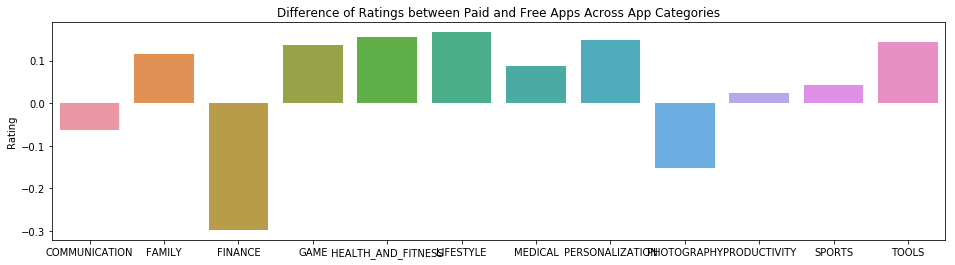

In [215]:
fig, ax = plt.subplots(figsize=(16,4))
sorted_idx = sorted(paid_stats.index)
rating_diff = paid_stats[sorted_idx] - free_stats[sorted_idx]
sns.barplot(x=sorted_idx, y=rating_diff, ax=ax).set_title("Difference of Ratings between Paid and Free Apps Across App Categories");
rating_diff

<b>Interpretation</b>

While paid apps are generally higher-rated than free apps, and so in most app categories, there are still some app categories where free apps are more likely to be favored than paid apps. For example, there are three categories of COMMUNICATION, FINANCE and PHOTOGRAPHY. The total number of free apps in the FINANCE group is almost 0.3 higher than the paid apps, which is also the highest.


<b> Are there any categories where the differences are statistically significant? </b>

In [216]:
def compute_utest(df):
    """
    Compute Mann-Whitney rank tests
    for paid and free app ratings
    """
    paid_rating = df.query('Type == "Paid"')['Rating']
    free_rating = df.query('Type == "Free"')['Rating']
    return mannwhitneyu(paid_rating, free_rating)

def cat_utest(df):
    """
    Iteratively compute utest for each app category
    """
    cats = set(df.Category)
    res = []
    for cat in cats:
        stats, pval = compute_utest(df.query('Category == "{}"'.format(cat)))
        res.append({'Category':cat,
                    'u_statistics':stats,
                    'p_value':pval})
    return pd.DataFrame(res)

uval, pval = compute_utest(df_rating)

print("General utest result: pval {}, u {}".format(pval, uval))
df_utest = cat_utest(df_rating)   
df_utest.loc[df_utest.p_value < .05] # significant categories

General utest result: pval 4.17841444099998e-10, u 1182741.0


,Category,p_value,u_statistics
1,FAMILY,0.000036,90258.0
4,TOOLS,0.003025,16327.0
5,PERSONALIZATION,0.002357,5845.5
9,GAME,0.000191,24001.0


<b>Interpretation</b>

Because ranking is not usually distributed, the Mann-Whitney U test was used to assess the importance of rating differences as this test is free of a conventional assumption. The findings of the u tests on different categories at the 0.05 significance rate show that the free and paid apps in the following categories have significant differences in rating: personalization, tools, family and games.